In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

DATA_EXT = (Path(os.getcwd()) / os.pardir / 'data' / 'external').resolve()

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *
from data.geo_utils import canonicalize_dataframe_geographies

In [6]:
who_df = pd.read_csv(Path('../data/interim/calc_cols_added.csv'), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth
1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth


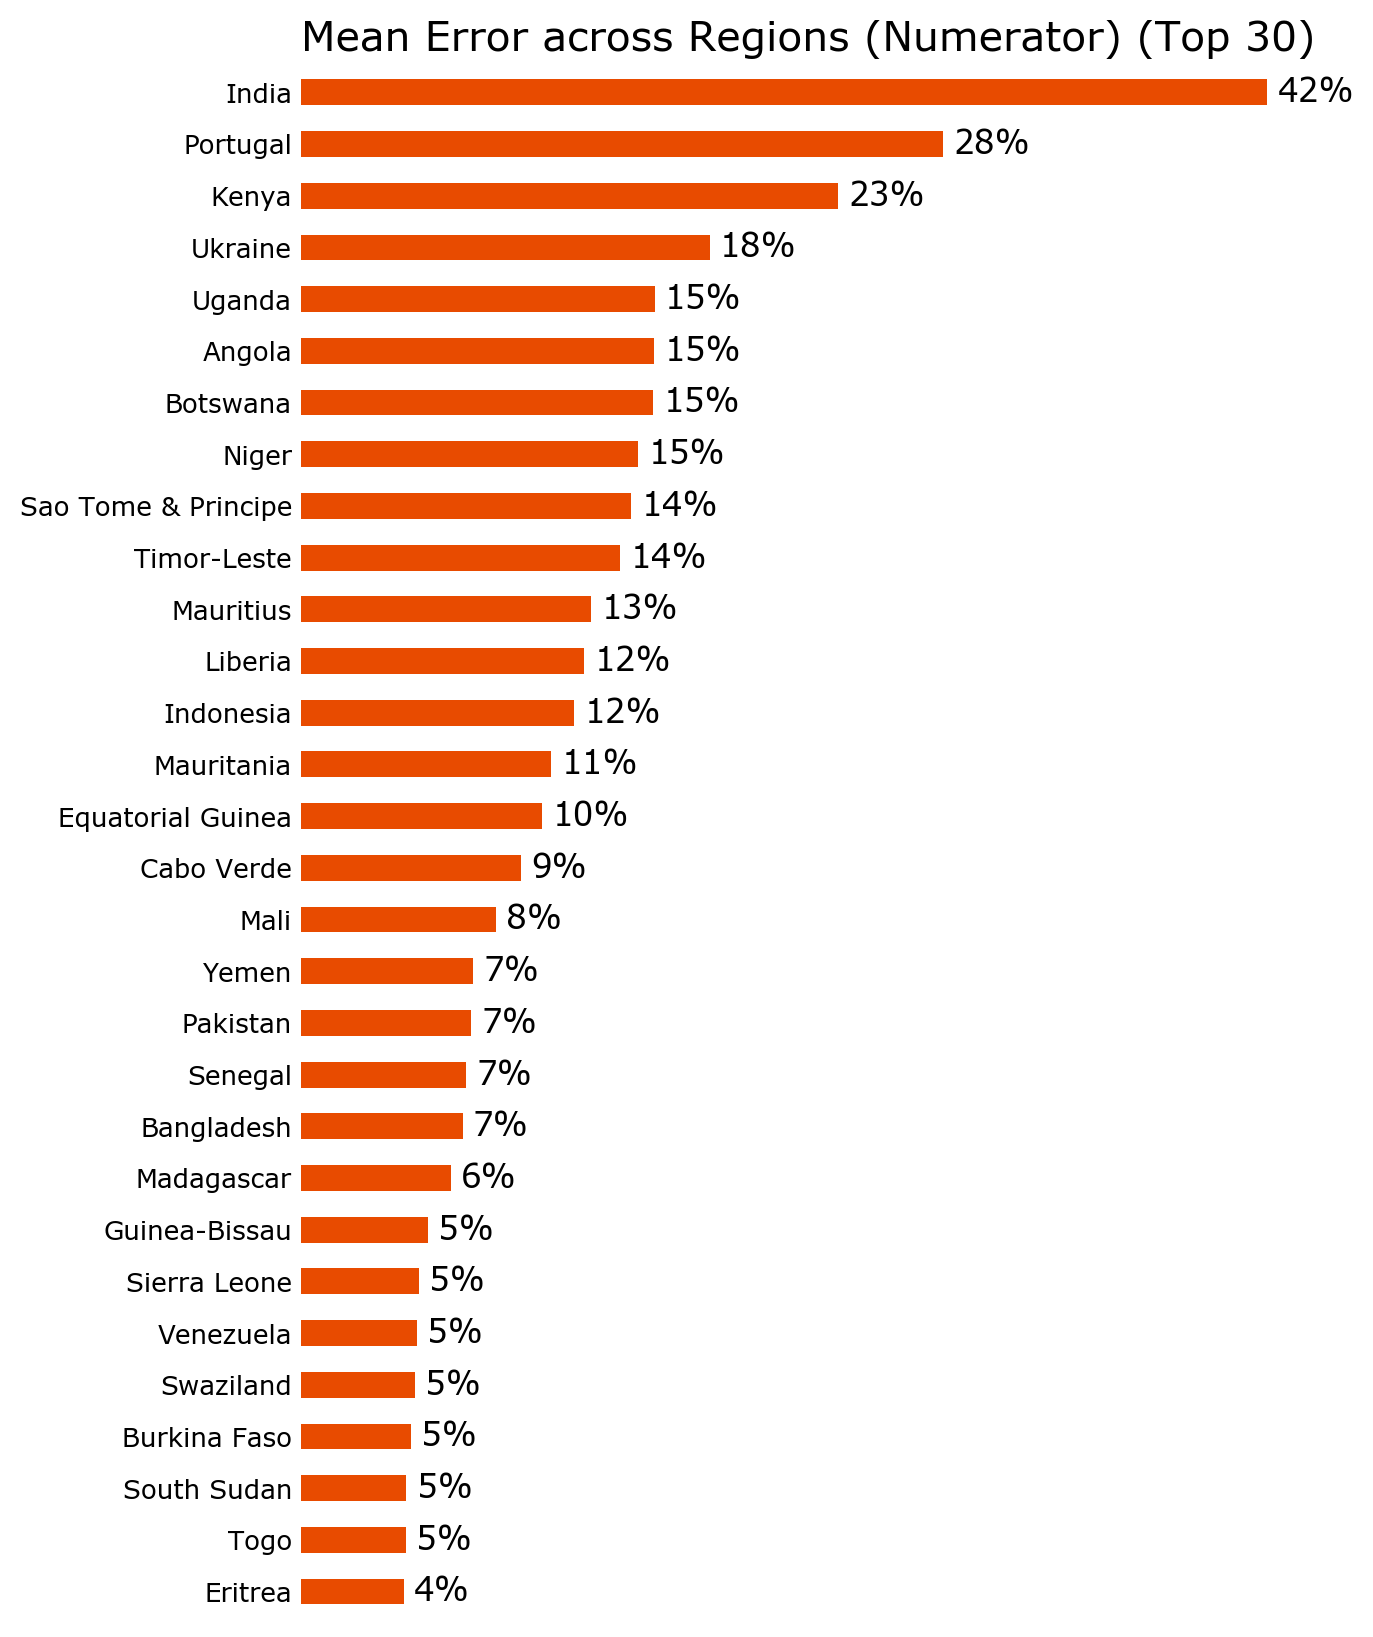

In [16]:
# numerator error, adminstered at same time
coef_var = (who_df.groupby(['Country Name', 'available_admin', 'timing'])
                  .recalc_numerator
                  .agg(lambda x: np.mean(np.abs(x - x.mean()) / x.mean()))
                  .dropna()
                  .reset_index()
                  .groupby('Country Name')
                  .recalc_numerator
                  .mean()
                  .dropna()
                  .sort_values(ascending=False))

to_plot = coef_var
PLOT_LIM = 30
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Error across Regions (Numerator) (Top {})'.format(PLOT_LIM))

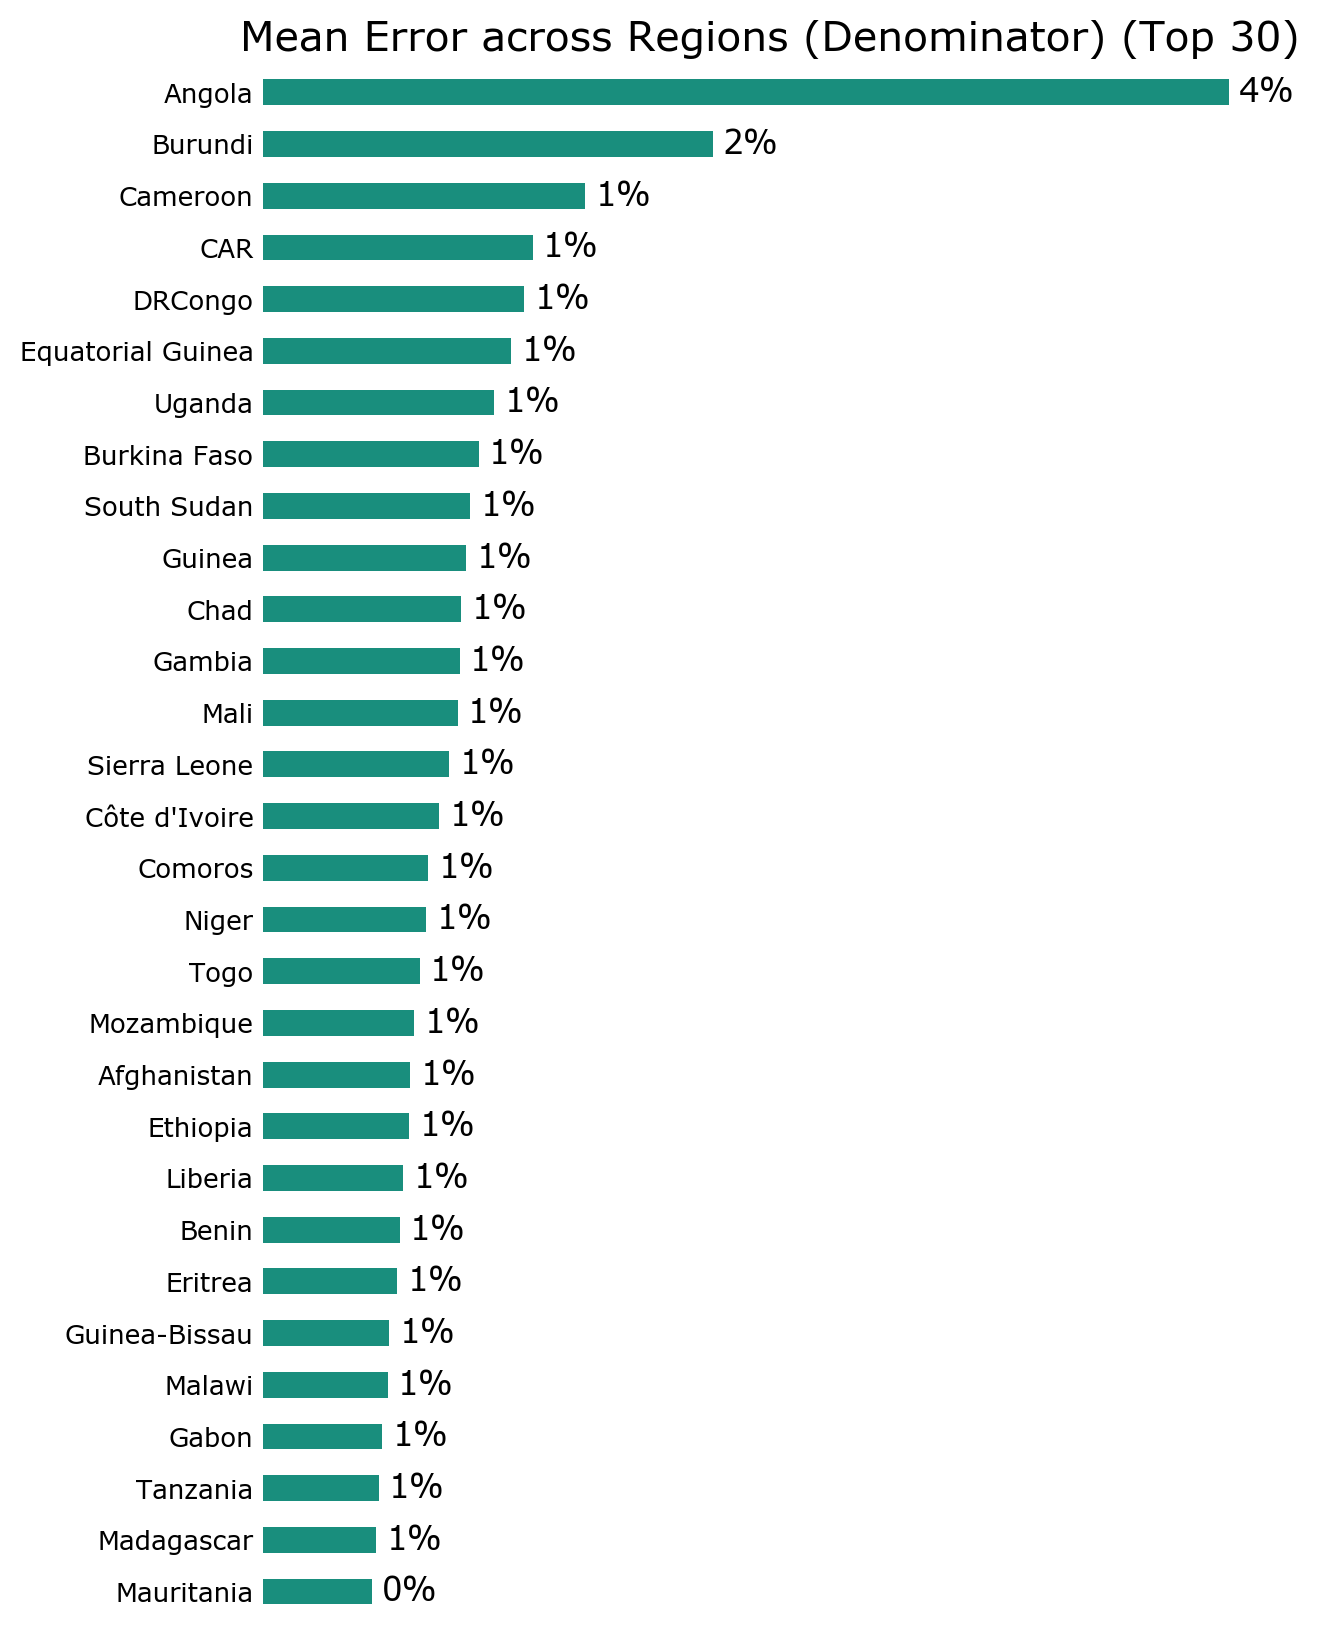

In [17]:
# denominator error, adminstered at same time
coef_var = (who_df.groupby(['Country Name', 'available_admin', 'timing'])
                  .Denominator
                  .agg(lambda x: np.mean(np.abs(x - x.mean()) / x.mean()))
                  .dropna()
                  .reset_index()
                  .groupby('Country Name')
                  .Denominator
                  .mean()
                  .dropna()
                  .sort_values(ascending=False))

to_plot = coef_var
PLOT_LIM = 30
FS=12

with styled_fig_ax(size='tallest', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['green']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Error across Regions (Denominator) (Top {})'.format(PLOT_LIM))

In [46]:
dropout = who_df[who_df['Vaccine Type'].isin(['DTP1', 'DTP3'])]

dtp_counts = (dropout.groupby(['Country Name', 'available_admin', 'Vaccine Type'])
        .recalc_numerator
        .first()
        .unstack(-1))

dropout_count = (dtp_counts
        .diff(axis=1)
        .DTP3)


mean_dropout = (dropout_count.divide(dtp_counts.DTP1)
                             .replace({np.inf: np.nan})
                             .dropna().abs().groupby('Country Name').mean().sort_values(ascending=False))

mean_dropout
# to_plot = mean_dropout

# PLOT_LIM = 50

# with styled_fig_ax(size='tall', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
#     labeled_bar(ax,
#                 to_plot.head(PLOT_LIM).sort_values(),
#                 font_size=FS,
#                 horizontal=True,
#                 label_formatter=pct_func_formatter(),
#                 color=PALETTE['orange']
#                )
    
    
#     ax.set_ylabel('')
#     ax.set_title('Mean Absolute Change D to MCV2, as percent of MCV2 (top {})'.format(PLOT_LIM))
    





Country Name
Sudan                   2.414348
Mexico                  0.842291
CAR                     0.307837
South Sudan             0.295798
Somalia                 0.281320
Suriname                0.212286
Bahamas                 0.206308
Venezuela               0.200009
Argentina               0.199879
Dominican Republic      0.195933
Angola                  0.184595
Guinea-Bissau           0.179209
Haiti                   0.170627
Trinidad & Tobago       0.167889
Peru                    0.166320
Saint Kitts & Nevis     0.161198
Mali                    0.159847
Bosnia & Herzegovina    0.154851
Panama                  0.154367
Kazakhstan              0.147165
Afghanistan             0.145361
Pakistan                0.141532
Chad                    0.141033
Guatemala               0.131978
Brazil                  0.131135
Mauritania              0.128449
Botswana                0.124264
Bolivia                 0.121556
Gabon                   0.110039
Guyana                  0.1095

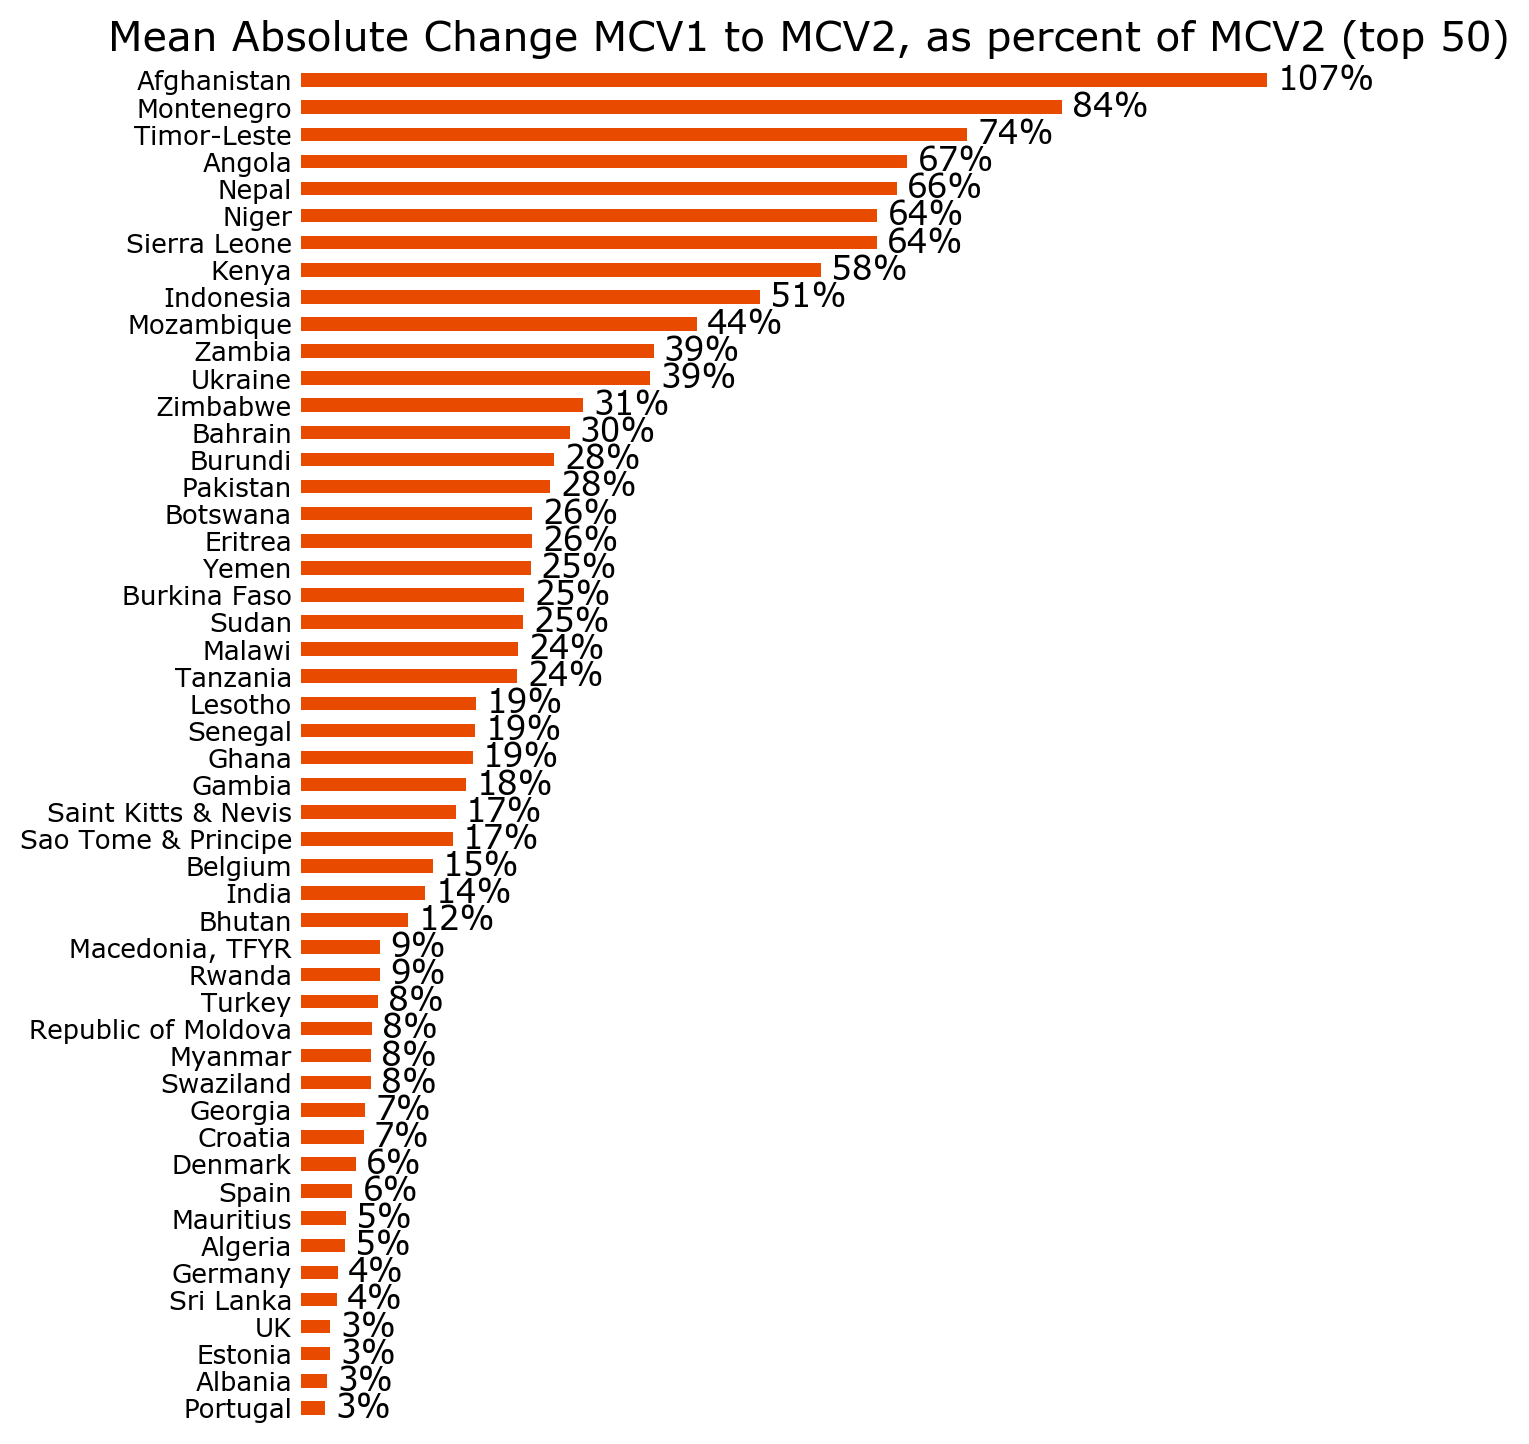

In [47]:
dropout = who_df[who_df['Vaccine Type'].isin(['MCV1', 'MCV2'])]

dtp_counts = (dropout.groupby(['Country Name', 'available_admin', 'Vaccine Type'])
        .recalc_numerator
        .first()
        .unstack(-1))

dropout_count = (dtp_counts
        .diff(axis=1)
        .MCV2)


mean_dropout2 = (dropout_count.divide(dtp_counts.MCV1)
                             .replace({np.inf: np.nan})
                             .dropna().abs().groupby('Country Name').mean().sort_values(ascending=False))


to_plot = mean_dropout2

PLOT_LIM = 50

with styled_fig_ax(size='tall', font_size=FS, x_formatter=pct_func_formatter(), zero_lines=False) as ax:
    labeled_bar(ax,
                to_plot.head(PLOT_LIM).sort_values(),
                font_size=FS,
                horizontal=True,
                label_formatter=pct_func_formatter(),
                color=PALETTE['orange']
               )
    
    
    ax.set_ylabel('')
    ax.set_title('Mean Absolute Change MCV1 to MCV2, as percent of MCV2 (top {})'.format(PLOT_LIM))
    





In [54]:
samesies = np.intersect1d(mean_dropout.index.values, mean_dropout2.index.values)

pd.DataFrame({
    'rank_dtp': mean_dropout[samesies].rank(ascending=False),
    'rank_mcv': mean_dropout2[samesies].rank(ascending=False)
}).mean(axis=1).sort_values()


Country Name
Afghanistan             3.0
Angola                  3.0
Niger                   7.5
Kenya                   9.0
Zambia                  9.5
Sudan                  10.5
Pakistan               10.5
Mozambique             10.5
Botswana               11.5
Sierra Leone           13.5
Zimbabwe               14.0
Nepal                  14.5
Saint Kitts & Nevis    15.0
Montenegro             15.5
Indonesia              17.0
Timor-Leste            17.0
Yemen                  17.5
Malawi                 17.5
Tanzania               18.5
Ghana                  19.0
Eritrea                19.0
Senegal                23.0
Myanmar                24.0
Burundi                24.5
Gambia                 24.5
Lesotho                25.0
Burkina Faso           26.5
Kazakhstan             26.5
Republic of Moldova    27.0
Georgia                28.0
Bahrain                30.0
Bhutan                 30.5
India                  31.5
Swaziland              32.5
Algeria                33.5
Denmark